<a href="https://colab.research.google.com/github/lucianoh34/RedesNeurais/blob/main/HuggingFace_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Extracao do Dataset
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9951k      0  0:00:08  0:00:08 --:--:-- 13.8M


In [3]:
# Divisao Dataset em Treino, Validação e Teste
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

In [4]:
# Crriacao diretórios de validação
for category in ["pos", "neg"]:
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname, val_dir / category / fname)

In [5]:
from tensorflow import keras

batch_size = 32

# Criando datasets de treino, validação e teste
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [6]:
# Logando no Hugging Face
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [7]:
# Import pipeline de análise de sentimento
from transformers import pipeline

# Usando um modelo disponível publicament
pipe = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [8]:
# Função para avaliar o modelo no conjunto de teste
from sklearn.metrics import accuracy_score
import numpy as np
import time

ypred = []
test_labels = []
start = time.time()

In [9]:
# número total de batches no dataset de teste
num_batches = test_ds.cardinality().numpy()
print(f"Total de batches: {num_batches}")

Total de batches: 782


In [11]:
#num_batches_to_run = 10  # Definindo o número de batches para rodar no caso de teste (pra evitarr de rodar tudo, toda hora)

# Aval modelo no dataset de teste
for batch, (inputs, targets) in enumerate(test_ds):
#    if batch >= num_batches_to_run:
#        break
    for i in range(len(inputs)):
        # Convertendo os dados do TensorFlow para texto
        text = inputs[i].numpy().decode('UTF-8')
        # Classificando a entrada usando o pipeline
        #text = inputs[i].numpy().decode('UTF-8')[:512]
        #yp = pipe(text)
        yp = pipe(text[:512])
        # Verificando a saída do pipeline
        #print(f"Texto: {text}")
        #print(f"Previsão: {yp}")
        # Armazenando o rótulo verdadeiro e a predição
        test_labels.append(int(targets[i].numpy() == 1))
        ypred.append(int(yp[0]['label'] == "POSITIVE"))
    # Imprimindo a acurácia e o tempo decorrido a cada lote
    #print(f"Batch {batch + 1}/{num_batches_to_run}, Tempo decorrido: {time.time() - start:.2f}s")
    print(f"Batch {batch + 1}/{num_batches}, Tempo decorrido: {time.time() - start:.2f}s")


# Exibindo a acurácia final
print(f"Acurácia final: {accuracy_score(test_labels, ypred):.4f}")


Batch 1/782, Tempo decorrido: 52.58s
Batch 2/782, Tempo decorrido: 62.86s
Batch 3/782, Tempo decorrido: 70.76s
Batch 4/782, Tempo decorrido: 79.34s
Batch 5/782, Tempo decorrido: 88.42s
Batch 6/782, Tempo decorrido: 96.05s
Batch 7/782, Tempo decorrido: 105.27s
Batch 8/782, Tempo decorrido: 112.82s
Batch 9/782, Tempo decorrido: 121.20s
Batch 10/782, Tempo decorrido: 130.35s
Batch 11/782, Tempo decorrido: 137.73s
Batch 12/782, Tempo decorrido: 146.53s
Batch 13/782, Tempo decorrido: 154.82s
Batch 14/782, Tempo decorrido: 163.23s
Batch 15/782, Tempo decorrido: 172.19s
Batch 16/782, Tempo decorrido: 179.57s
Batch 17/782, Tempo decorrido: 188.50s
Batch 18/782, Tempo decorrido: 196.76s
Batch 19/782, Tempo decorrido: 204.93s
Batch 20/782, Tempo decorrido: 213.28s
Batch 21/782, Tempo decorrido: 220.90s
Batch 22/782, Tempo decorrido: 231.77s
Batch 23/782, Tempo decorrido: 240.08s
Batch 24/782, Tempo decorrido: 248.21s
Batch 25/782, Tempo decorrido: 257.31s
Batch 26/782, Tempo decorrido: 264.73s
B

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Avaliação preliminar
accuracy = accuracy_score(test_labels, ypred)
precision = precision_score(test_labels, ypred, zero_division=0)
recall = recall_score(test_labels, ypred, zero_division=0)
f1 = f1_score(test_labels, ypred, zero_division=0)

print(f"\nAvaliação Preliminar:")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Avaliação Preliminar:
Acurácia: 0.8283
Precisão: 0.8483
Recall: 0.7995
F1-Score: 0.8232


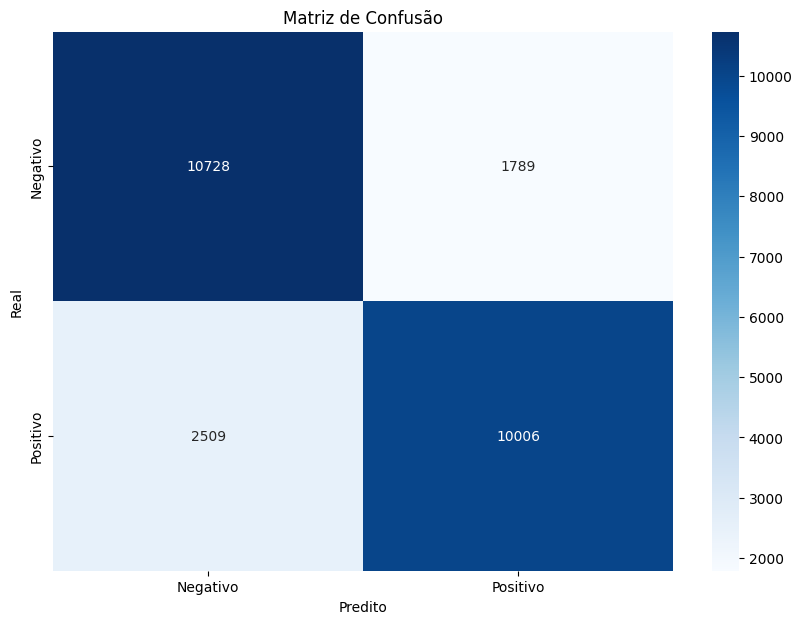

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
cm = confusion_matrix(test_labels, ypred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [14]:
# Exibindo alguns exemplos de previsões
#Validacao interna

sample_size = 10
random_indices = random.sample(range(len(test_labels)), sample_size)

for idx in random_indices:
    text = test_ds.unbatch().skip(idx).take(1)
    for sample in text:
        input_text = sample[0].numpy().decode('UTF-8')
        prediction = pipe(input_text[:512])[0]
        real_label = sample[1].numpy()
        print(f"Texto: {input_text[:512]}")
        print(f"Predição: {prediction['label']} - Confiança: {prediction['score']:.2f}")
        print(f"Real: {'Positivo' if real_label == 1 else 'Negativo'}")
        print("-" * 50)

Texto: There is not much of a plot to this movie. There is a wealthy baseball team owner who dies and whose wife is going to sue the hospital for neglience. Not much more than that, but .... IT DOES NOT MATTER!<br /><br />It does not matter because you have some real actors giving their dialogue life, and because of the cast you have yourself some hysterically funny scenes and even if you're not cracking up laughing, you have a smile on your face. <br /><br />Matthau plays Charley, whose wife recently passed away,
Predição: NEGATIVE - Confiança: 0.55
Real: Positivo
--------------------------------------------------
Texto: With all the hype surrounding the stars of the movie, this movie left me wanting. I expected a much better movie considering the inclusion of the talents of Murphy, De Niro and Russo but found that the movie fell flat on it's face. Comedy sequences were overdone and the superior performances of the stars especially De Niro and Russo couldn't save this one!<br /><br />